<a href="https://colab.research.google.com/github/abhi12ravi/BERTopic_Conf42/blob/main/Named_Entity_Recognition_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install tensorflow keras seaborn seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=0841094056021f6e01ed1f760a371e4081ed923f04626866d2039b2e4bfe3ca7
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


# Data Visualizaion

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from wordcloud import WordCloud
import re

# Set style for plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Load the dataset
df = pd.read_csv('ner_dataset.csv', encoding='latin1')

# Basic inspection
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Function to group data by sentences
def group_by_sentences(df):
    sentences = []
    current_sentence = []
    current_sent_num = -1

    for _, row in df.iterrows():
        # Check if this is a new sentence
        if pd.notna(row['Sentence #']) and row['Sentence #'] != current_sent_num:
            if current_sentence:  # Add the previous sentence if it exists
                sentences.append(current_sentence)
            current_sentence = []
            current_sent_num = row['Sentence #']

        # Skip NaN rows (empty lines between sentences)
        if pd.isna(row['Word']):
            continue

        # Add the word and its tag to the current sentence
        current_sentence.append((row['Word'], row['POS'], row['Tag']))

    # Add the last sentence
    if current_sentence:
        sentences.append(current_sentence)

    return sentences

# Group by sentences
sentences = group_by_sentences(df)

print(f"\nTotal number of sentences: {len(sentences)}")

# Basic statistics
sentence_lengths = [len(s) for s in sentences]
print(f"Average sentence length: {np.mean(sentence_lengths):.2f} words")
print(f"Minimum sentence length: {min(sentence_lengths)} words")
print(f"Maximum sentence length: {max(sentence_lengths)} words")

# Vocabulary analysis
all_words = [row['Word'].lower() for _, row in df.iterrows() if pd.notna(row['Word'])]
unique_words = set(all_words)
print(f"\nTotal words: {len(all_words)}")
print(f"Unique words: {len(unique_words)}")

# NER tag analysis
all_tags = [row['Tag'] for _, row in df.iterrows() if pd.notna(row['Tag'])]
tag_counts = Counter(all_tags)

print("\nNER tag distribution:")
for tag, count in tag_counts.most_common():
    print(f"{tag}: {count} ({count/len(all_tags)*100:.2f}%)")

# Entity type extraction
entity_types = set()
for tag in tag_counts.keys():
    if tag != 'O':
        entity_type = tag.split('-')[1] if '-' in tag else tag
        entity_types.add(entity_type)

print(f"\nEntity types found: {', '.join(sorted(entity_types))}")

# Entity span analysis
entity_spans = []
current_entity = []
current_type = ""

for sentence in sentences:
    for word, _, tag in sentence:
        if tag.startswith('B-'):
            # End previous entity if exists
            if current_entity:
                entity_spans.append((' '.join(current_entity), current_type))
                current_entity = []
            # Start new entity
            current_entity = [word]
            current_type = tag.split('-')[1]
        elif tag.startswith('I-'):
            # Continue current entity
            if current_entity:  # Only add if there's a current entity
                current_entity.append(word)
        else:  # 'O' tag
            # End previous entity if exists
            if current_entity:
                entity_spans.append((' '.join(current_entity), current_type))
                current_entity = []
                current_type = ""

    # End entity at sentence boundary if exists
    if current_entity:
        entity_spans.append((' '.join(current_entity), current_type))
        current_entity = []
        current_type = ""

# Entity length analysis
entity_lengths = [len(entity.split()) for entity, _ in entity_spans]
entity_types_count = Counter([entity_type for _, entity_type in entity_spans])

print(f"\nTotal named entities: {len(entity_spans)}")
print(f"Average entity length: {np.mean(entity_lengths):.2f} words")

print("\nEntity type distribution:")
for entity_type, count in entity_types_count.most_common():
    print(f"{entity_type}: {count} ({count/len(entity_spans)*100:.2f}%)")

# Common words per tag
words_by_tag = defaultdict(list)
for _, row in df.iterrows():
    if pd.notna(row['Word']) and pd.notna(row['Tag']):
        words_by_tag[row['Tag']].append(row['Word'].lower())

print("\nMost common words for each tag (top 5):")
for tag, words in words_by_tag.items():
    if tag != 'O' and len(words) > 0:  # Skip 'O' tag as it's less informative
        print(f"{tag}: {', '.join([word for word, _ in Counter(words).most_common(5)])}")

# Word case analysis for entities
entity_case_patterns = {
    'lowercase': 0,
    'titlecase': 0,
    'uppercase': 0,
    'mixed': 0
}

for entity, _ in entity_spans:
    if entity.islower():
        entity_case_patterns['lowercase'] += 1
    elif entity.istitle():
        entity_case_patterns['titlecase'] += 1
    elif entity.isupper():
        entity_case_patterns['uppercase'] += 1
    else:
        entity_case_patterns['mixed'] += 1

print("\nEntity case patterns:")
for pattern, count in entity_case_patterns.items():
    print(f"{pattern}: {count} ({count/len(entity_spans)*100:.2f}%)")

# Class imbalance assessment
non_entity_count = tag_counts.get('O', 0)
entity_count = sum(count for tag, count in tag_counts.items() if tag != 'O')
print(f"\nNon-entity words (O tag): {non_entity_count} ({non_entity_count/len(all_tags)*100:.2f}%)")
print(f"Entity words (B- and I- tags): {entity_count} ({entity_count/len(all_tags)*100:.2f}%)")

# Context analysis (words before and after entities)
before_entity = []
after_entity = []

for sentence in sentences:
    for i, (word, _, tag) in enumerate(sentence):
        if tag.startswith('B-'):
            if i > 0:
                before_entity.append(sentence[i-1][0].lower())
        elif tag == 'O' and i > 0 and sentence[i-1][2].startswith('I-'):
            after_entity.append(word.lower())

print("\nTop 10 words appearing before entities:")
for word, count in Counter(before_entity).most_common(10):
    print(f"{word}: {count}")

print("\nTop 10 words appearing after entities:")
for word, count in Counter(after_entity).most_common(10):
    print(f"{word}: {count}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=50, alpha=0.7)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig('sentence_length_distribution.png')
plt.close()

# Plot distribution of entity lengths
plt.figure(figsize=(12, 6))
plt.hist(entity_lengths, bins=range(1, max(entity_lengths) + 2), alpha=0.7)
plt.title('Entity Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xticks(range(1, max(entity_lengths) + 1))
plt.grid(True, alpha=0.3)
plt.savefig('entity_length_distribution.png')
plt.close()

# Plot tag distribution
plt.figure(figsize=(14, 8))
tags = [tag for tag, _ in tag_counts.most_common()]
counts = [count for _, count in tag_counts.most_common()]
sns.barplot(x=tags, y=counts)
plt.title('NER Tag Distribution')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tag_distribution.png')
plt.close()

# Plot entity type distribution
plt.figure(figsize=(12, 6))
entity_types = [entity_type for entity_type, _ in entity_types_count.most_common()]
counts = [count for _, count in entity_types_count.most_common()]
sns.barplot(x=entity_types, y=counts)
plt.title('Entity Type Distribution')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('entity_type_distribution.png')
plt.close()

# Word clouds for each entity type
for entity_type in set(entity_type for _, entity_type in entity_spans):
    entity_words = ' '.join([entity.lower() for entity, type_ in entity_spans if type_ == entity_type])

    if entity_words:
        wordcloud = WordCloud(width=800, height=400,
                              background_color='white',
                              max_words=100,
                              contour_width=3,
                              contour_color='steelblue')
        wordcloud.generate(entity_words)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {entity_type} Entities')
        plt.axis('off')
        plt.savefig(f'wordcloud_{entity_type}.png')
        plt.close()

# Data splitting considerations
print("\nData splitting considerations:")
print("1. Split by sentences rather than random words to maintain entity integrity")
print("2. Ensure representation of rare entity types across splits")
print("3. Consider stratified sampling based on entity types to maintain distribution")

# Calculate potential for feature engineering
print("\nPotential features for NER model:")
print("1. Word case (uppercase, lowercase, titlecase)")
print("2. Word shape (patterns of letters, digits, and punctuation)")
print("3. Word suffixes and prefixes")
print("4. POS tags")
print("5. Word embeddings (pre-trained or custom)")
print("6. Character-level features")
print("7. Dictionary/gazetteer features for known entities")

# Create a sample sentence visualization
def visualize_ner_sentence(sentence_idx=0):
    sentence = sentences[sentence_idx]
    words = [word for word, _, _ in sentence]
    tags = [tag for _, _, tag in sentence]

    colors = {
        'O': 'lightgrey',
        'B-PER': 'lightcoral',
        'I-PER': 'lightcoral',
        'B-ORG': 'lightblue',
        'I-ORG': 'lightblue',
        'B-LOC': 'lightgreen',
        'I-LOC': 'lightgreen',
        'B-MISC': 'lightyellow',
        'I-MISC': 'lightyellow',
        'B-geo': 'lightgreen',
        'I-geo': 'lightgreen',
        'B-tim': 'peachpuff',
        'I-tim': 'peachpuff',
        'B-art': 'plum',
        'I-art': 'plum',
        'B-eve': 'lightpink',
        'I-eve': 'lightpink',
        'B-nat': 'lightcyan',
        'I-nat': 'lightcyan',
    }

    # Default color for unknown tags
    default_color = 'white'

    fig, ax = plt.subplots(figsize=(12, 3))
    for i, (word, tag) in enumerate(zip(words, tags)):
        color = colors.get(tag, default_color)
        ax.text(i, 0.5, word, ha='center', va='center', bbox=dict(facecolor=color, alpha=0.5))

    ax.set_xlim(-0.5, len(words) - 0.5)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Sample Sentence with NER Tags')

    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[tag], label=tag)
                      for tag in set(tags) if tag in colors]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

    plt.tight_layout()
    plt.savefig('sample_sentence_ner.png')
    plt.close()

# Visualize a sample sentence (first sentence by default)
visualize_ner_sentence()

# Suggest train/val/test split approach
total_sentences = len(sentences)
print("\nSuggested data split:")
print(f"Training set: {int(total_sentences * 0.7)} sentences ({70}%)")
print(f"Validation set: {int(total_sentences * 0.1)} sentences ({10}%)")
print(f"Test set: {int(total_sentences * 0.2)} sentences ({20}%)")

# Generate a summary of findings
print("\nSummary of EDA findings:")
print(f"1. Dataset contains {len(sentences)} sentences with {len(all_words)} words.")
print(f"2. Average sentence length is {np.mean(sentence_lengths):.2f} words.")
print(f"3. There are {len(entity_spans)} named entities with average length of {np.mean(entity_lengths):.2f} words.")
print(f"4. Most common entity type is {entity_types_count.most_common(1)[0][0]}.")
print(f"5. {entity_count/len(all_tags)*100:.2f}% of words are part of named entities.")
print(f"6. Most entities ({entity_case_patterns['titlecase']/len(entity_spans)*100:.2f}%) follow title case pattern.")
print("7. Dataset shows imbalance in entity types, which should be considered during modeling.")

Dataset Shape: (1048575, 4)

First few rows:
    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O

Missing values per column:
Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

Total number of sentences: 47959
Average sentence length: 21.86 words
Minimum sentence length: 1 words
Maximum sentence length: 104 words

Total words: 1048565
Unique words: 31817

NER tag distribution:
O: 887908 (84.68%)
B-geo: 37644 (3.59%)
B-tim: 20333 (1.94%)
B-org: 20143 (1.92%)
I-per: 17251 (1.65%)
B-per: 16990 (1.62%)
I-org: 16784 (1.60%)
B-gpe: 15870 (1.51%)
I-geo: 7414 (0.71%)
I-tim: 6528 (0.62%)
B-art: 402 (0.04%)
B-eve: 308 (0.03%)
I-art: 297 (0.03%)
I-eve: 253 (0.02%)
B-nat: 201 (0.02%)
I-gpe: 198 (0.02%)
I-nat: 51 (0.00%)

Entity types found: art, eve, geo, gpe, nat, org,

# Baseline Model

In [45]:
!pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00


Step 1: Loading and exploring the data...
Dataset shape: (1048575, 4)

First few rows of the dataset:
    Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1          NaN             of   IN      O
2          NaN  demonstrators  NNS      O
3          NaN           have  VBP      O
4          NaN        marched  VBN      O
5          NaN        through   IN      O
6          NaN         London  NNP  B-geo
7          NaN             to   TO      O
8          NaN        protest   VB      O
9          NaN            the   DT      O

Missing values in each column:
Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

Distribution of NER tags:
Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51


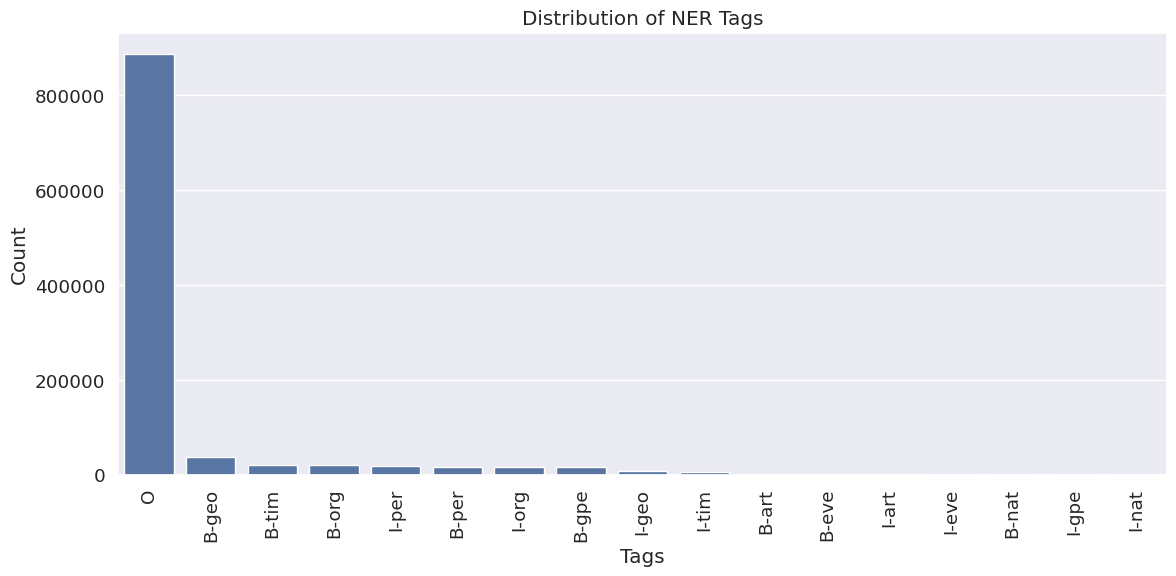

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn_crfsuite import CRF
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Step 1: Data Loading and Exploration
def load_and_explore_data(file_path):
    print("Step 1: Loading and exploring the data...")

    # Load the dataset
    data = pd.read_csv(file_path, encoding='latin1')

    # Display basic information
    print(f"Dataset shape: {data.shape}")
    print("\nFirst few rows of the dataset:")
    print(data.head(10))

    # Check for missing values
    print("\nMissing values in each column:")
    print(data.isnull().sum())

    # Replace NaN values with empty string for 'Word' column
    data['Word'] = data['Word'].fillna('')

    # Explore the distribution of NER tags
    print("\nDistribution of NER tags:")
    tag_counts = data['Tag'].value_counts()
    print(tag_counts)

    # Visualize tag distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tag_counts.index, y=tag_counts.values)
    plt.title('Distribution of NER Tags')
    plt.xlabel('Tags')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('ner_tag_distribution.png')

    return data

# Step 2: Data Preprocessing
def preprocess_data(data):
    print("\nStep 2: Preprocessing the data...")

    # Group data by sentence
    sentences = []
    sentence = []

    for idx, row in data.iterrows():
        # Check if we have a new sentence
        if row['Sentence #'] != data.iloc[idx-1]['Sentence #'] if idx > 0 else True:
            if sentence:
                sentences.append(sentence)
            sentence = []

        # Skip empty words
        if row['Word'] == '':
            continue

        # Add the word and its tag to the current sentence
        sentence.append((row['Word'], row['Tag']))

    # Add the last sentence if it exists
    if sentence:
        sentences.append(sentence)

    print(f"Total number of sentences: {len(sentences)}")
    print(f"Sample sentence with tags: {sentences[0]}")

    # Create word and tag vocabularies
    words = [word for sentence in sentences for word, _ in sentence]
    tags = [tag for sentence in sentences for _, tag in sentence]

    word_counts = Counter(words)
    tag_counts = Counter(tags)

    print(f"\nVocabulary size: {len(word_counts)}")
    print(f"Number of unique tags: {len(tag_counts)}")
    print("\nMost common words:")
    print(word_counts.most_common(10))
    print("\nMost common tags:")
    print(tag_counts.most_common())

    return sentences, word_counts, tag_counts

# Function to extract features for CRF
def word2features(sent, i):
    word = sent[i][0]

    # Basic features
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit()
    }

    # Features for previous word
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper()
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    # Features for next word
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper()
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Convert sentences to features and labels
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

# Step 3: Dataset Splitting
def split_dataset(sentences):
    print("\nStep 3: Splitting the dataset...")

    # First split: 80% train+val, 20% test
    train_val, test = train_test_split(sentences, test_size=0.2, random_state=42)

    # Second split: 80% train, 20% validation (from the 80% train+val)
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)

    print(f"Training set size: {len(train)} sentences")
    print(f"Validation set size: {len(val)} sentences")
    print(f"Test set size: {len(test)} sentences")

    # Convert to features and labels
    X_train = [sent2features(s) for s in train]
    y_train = [sent2labels(s) for s in train]

    X_val = [sent2features(s) for s in val]
    y_val = [sent2labels(s) for s in val]

    X_test = [sent2features(s) for s in test]
    y_test = [sent2labels(s) for s in test]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Step 4: Baseline Model Development
def develop_baseline_model(X_train, y_train):
    print("\nStep 4: Developing the baseline model...")

    # Initialize CRF model
    crf = CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )

    # Train the model
    print("Training the model...")
    crf.fit(X_train, y_train)

    print("Model training completed!")
    return crf

# Step 5: Baseline Evaluation
def evaluate_model(model, X_val, y_val):
    print("\nStep 5: Evaluating the baseline model...")

    # Make predictions
    y_pred = model.predict(X_val)

    # Flatten the lists for evaluation
    y_true_flat = [tag for sublist in y_val for tag in sublist]
    y_pred_flat = [tag for sublist in y_pred for tag in sublist]

    # Print classification report
    report = classification_report(y_true_flat, y_pred_flat)
    print("\nClassification Report:")
    print(report)

    # Calculate tag-wise accuracy
    tag_accuracy = {}
    for true_tag, pred_tag in zip(y_true_flat, y_pred_flat):
        if true_tag not in tag_accuracy:
            tag_accuracy[true_tag] = {'correct': 0, 'total': 0}
        tag_accuracy[true_tag]['total'] += 1
        if true_tag == pred_tag:
            tag_accuracy[true_tag]['correct'] += 1

    print("\nTag-wise Accuracy:")
    for tag, counts in tag_accuracy.items():
        accuracy = counts['correct'] / counts['total'] * 100
        print(f"{tag}: {accuracy:.2f}% ({counts['correct']}/{counts['total']})")

    return y_pred, report

# Main execution function
def main(file_path='ner_dataset.csv'):
    # Step 1: Load and explore data
    data = load_and_explore_data(file_path)

    # Step 2: Preprocess data
    sentences, word_counts, tag_counts = preprocess_data(data)

    # Step 3: Split dataset
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(sentences)

    # Step 4: Develop baseline model
    model = develop_baseline_model(X_train, y_train)

    # Step 5: Evaluate model
    y_pred, report = evaluate_model(model, X_val, y_val)

    print("\nAll steps completed successfully!")
    return model, sentences, (X_val, y_val), (X_test, y_test), (X_train, y_train)  # Return the model and test data for future use

# If this script is run directly
if __name__ == "__main__":
    model_baseline, sentences, (X_test, y_test), (X_val, y_val), (X_train, y_train)   = main()

# Advanced Model

In [4]:
#import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
#plt.style.use('seaborn-v0_8')

In [6]:
data=pd.read_csv('ner_dataset.csv',encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [7]:
#Drop the POS column as we do not need it
data.drop('POS',axis='columns',inplace=True)

In [8]:
data.head(15)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
5,NaN,through,O
6,NaN,London,B-geo
7,NaN,to,O
8,NaN,protest,O
9,NaN,the,O


In [9]:
#NaN values to be filled using Forward Fill method.
data=data.fillna(method='ffill')

<ipython-input-9-45638fe461c8>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data=data.fillna(method='ffill')


In [10]:
data.head(35)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [11]:
'''Extracting unique values from the 'Word' column of the DataFrame data. It is using the set() function
to create a set of unique words and then converting that set back into a list. So, the variable words
will contain a list of unique words found in the 'Word' column of the DataFrame.'''

words=list(set(data['Word'].values))

'''Adding the string "ENDPAD" to the end of the words list. The term "ENDPAD" is often used in natural
language processing tasks, such as sequence labeling, to indicate the end of a sequence. It's a common
practice to have a special token like this in NLP tasks.'''

words.append("ENDPAD")

''' Accessing the last element of the words list, which is now "ENDPAD". By using the index -1, referencing the last element in the list.'''
words[-1]

'ENDPAD'

In [12]:
words[-10:]

['Borg',
 '555',
 'Sandinista',
 'definite',
 'Embracing',
 'disrespectful',
 'enjoyed',
 'Bashar',
 'Whitman',
 'ENDPAD']

In [13]:
#Total no. of words
num_words=len(data['Word'])
print("Total number of words",num_words)

Total number of words 1048575


In [14]:
#List of Tags and total no. of Tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: B-gpe, B-org, B-tim, B-per, B-geo, B-eve, I-eve, I-org, B-art, I-gpe, O, I-nat, I-tim, B-nat, I-geo, I-per, I-art
Total Number of tags 17


In [15]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [16]:
#Creating a class which will give the complete sentence with Tags attached with each word
class Get_sentence(object):
  def __init__(self,data):
    self.n_sent=1
    self.data=data
    agg_func=lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    self.sentences=[s for s in self.grouped]

In [17]:
getter=Get_sentence(data)
sentence=getter.sentences

<ipython-input-16-7a59fbbb5a8b>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped=self.data.groupby('Sentence #').apply(agg_func)


In [18]:
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

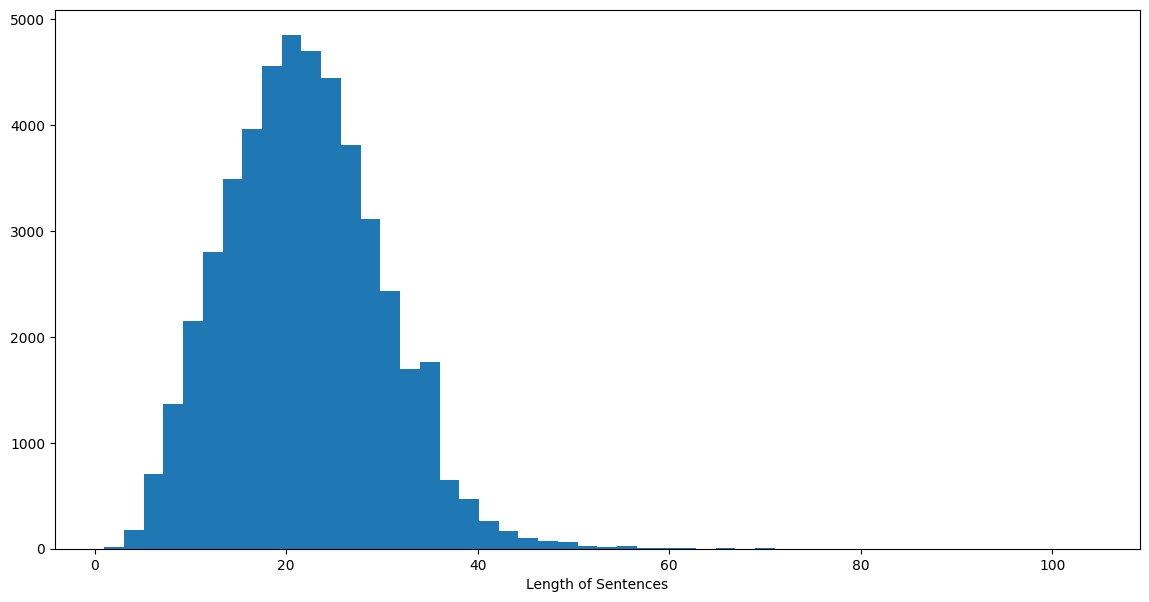

In [19]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

Most of our sentenses have a length of 20 words, the longest sentense is around 63 words


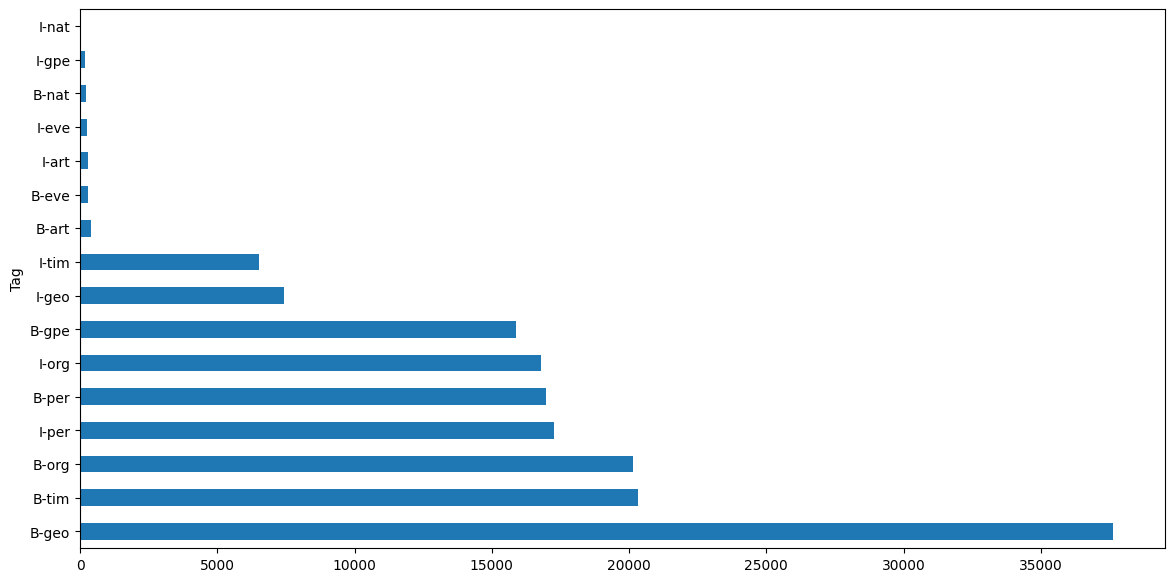

In [20]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

## We can understand from the bar chart above that B-geo Tags are over-represented.
## I-nat and I-gpe Tags are negligible and almost non-existent. Model will have difficulty in classifying these 2 tags.

## Data Preparation

In [21]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [22]:
len(tag_idx)

17

In [23]:
word_idx['PAD']=0

In [24]:
word_idx['Dniester']

220

In [25]:
# Padding our sentences using max lenght of 50.
max_len=50
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])


In [26]:
X[0]

array([  18884,   30918,    8107,   26675,   18886,    7241,   21045,
           766,   33358,   25225,   23700,   23765,   27505,   30205,
          7060,   25225,   33406,   30918,    6220,    2312,    8448,
          3877,   31037,    2796, 1048574, 1048574, 1048574, 1048574,
       1048574, 1048574, 1048574, 1048574, 1048574, 1048574, 1048574,
       1048574, 1048574, 1048574, 1048574, 1048574, 1048574, 1048574,
       1048574, 1048574, 1048574, 1048574, 1048574, 1048574, 1048574,
       1048574], dtype=int32)

In [27]:
y[0]

array([10, 10, 10, 10, 10, 10,  4, 10, 10, 10, 10, 10,  4, 10, 10, 10, 10,
       10,  0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)

In [28]:
y=[to_categorical(i,num_classes=num_tags) for i in y]

In [29]:
num_tags

17

In [30]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0

In [31]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [32]:
# Building the model

In [33]:
input_word=Input(shape=(max_len,))
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model=Model(input_word,out)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 50)              │      52,428,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,552,967 (200.47 MB)

 Trainable params: 52,552,967 (200.47 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [35]:
#Training the model with Training data
model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=3,validation_split=0.2)

Epoch 1/3
480/480 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.9244 - loss: 0.4439 - val_accuracy: 0.9701 - val_loss: 0.1067
Epoch 2/3
480/480 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.9754 - loss: 0.0873 - val_accuracy: 0.9824 - val_loss: 0.0600
Epoch 3/3
480/480 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - accuracy: 0.9858 - loss: 0.0487 - val_accuracy: 0.9845 - val_loss: 0.0514


## Model Evaluation

In [36]:
model.evaluate(X_test,np.array(y_test))

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9840 - loss: 0.0540


[0.05312096327543259, 0.9843102693557739]

In [43]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, accuracy_score
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import precision_score as seq_precision_score
from seqeval.metrics import accuracy_score as seq_accuracy_score

# Get predictions from your model
y_pred = model.predict(X_test)

# Convert predictions to class indices
if len(y_pred.shape) > 2:  # One-hot encoded predictions
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_test_classes = np.argmax(np.array(y_test), axis=-1)
else:
    y_pred_classes = y_pred  # Already class indices
    y_test_classes = np.array(y_test)

# Mask padded tokens if you have variable length sequences
# Assuming 0 is your padding token index
mask = y_test_classes != 0

# Token-level metrics
token_level_accuracy = accuracy_score(y_test_classes[mask], y_pred_classes[mask])

# Find unique classes in the data to ensure we have the right number of labels
unique_classes = np.unique(np.concatenate([y_test_classes[mask], y_pred_classes[mask]]))
print(f"Found {len(unique_classes)} unique classes: {unique_classes}")

# Don't specify target_names for now, let sklearn determine from the data
token_level_report = classification_report(
    y_test_classes[mask],
    y_pred_classes[mask],
    digits=4
)

print("Token-level Accuracy:", token_level_accuracy)
print("\nToken-level Classification Report:")
print(token_level_report)

# For a more complete report with your actual tag names, you would need
# to create a mapping for all 17 classes. Here's a placeholder:
idx2tag = {
    0: "PAD",  # assuming 0 is padding
    # Fill in the rest of your 17 classes here
    # 1: "B-PERSON",
    # 2: "I-PERSON",
    # ...and so on
}

# Print overall precision
overall_precision = precision_score(y_test_classes[mask], y_pred_classes[mask], average='weighted')
print("\nOverall Precision (weighted):", overall_precision)



300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Found 17 unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Token-level Accuracy: 0.9846818085456953

Token-level Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.8069    0.6246    0.7042      3908
           2     0.9306    0.8403    0.8832      4102
           3     0.8370    0.7916    0.8136      3359
           4     0.8498    0.8917    0.8703      7380
           5     0.0000    0.0000    0.0000        79
           6     0.0000    0.0000    0.0000        73
           7     0.8164    0.7010    0.7543      3254
           8     0.0000    0.0000    0.0000        96
           9     0.0000    0.0000    0.0000        33
          10     0.9937    0.9975    0.9956    447795
          11     0.0000    0.0000    0.0000        12
          12     0.7458    0.7558    0.7507      1339
          13     0.0000    0.0000    0.0000   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [45]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, accuracy_score, confusion_matrix

# Get predictions from your model
y_pred = model.predict(X_test)

# Convert predictions to class indices
if len(y_pred.shape) > 2:  # One-hot encoded predictions
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_test_classes = np.argmax(np.array(y_test), axis=-1)
else:
    y_pred_classes = y_pred  # Already class indices
    y_test_classes = np.array(y_test)

# Flatten both arrays for standard classification metrics
# This treats NER as a token classification task
y_true_flat = y_test_classes.flatten()
y_pred_flat = y_pred_classes.flatten()

# Remove padding tokens (assuming 0 is padding)
mask = y_true_flat != 0
y_true_flat = y_true_flat[mask]
y_pred_flat = y_pred_flat[mask]

# Get unique classes to understand what classes are in the data
unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
print(f"Found {len(unique_classes)} unique classes: {unique_classes}")

# Calculate token-level metrics
token_accuracy = accuracy_score(y_true_flat, y_pred_flat)
token_precision = precision_score(y_true_flat, y_pred_flat, average='weighted')
token_report = classification_report(y_true_flat, y_pred_flat, digits=4)

print(f"\nToken-level Accuracy: {token_accuracy:.4f}")
print(f"Token-level Precision (weighted): {token_precision:.4f}")
print("\nToken-level Classification Report:")
print(token_report)

# Generate confusion matrix to see which classes are confused with others
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nNote: For entity-level evaluation (evaluating complete entity spans rather than individual tokens),")
print("you would need to provide the mapping from class indices to your NER tags (like B-PER, I-LOC, etc.)")
print("and use a library like seqeval that understands the BIO tagging scheme.")

300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
Found 17 unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

Token-level Accuracy: 0.9847
Token-level Precision (weighted): 0.9837

Token-level Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.8069    0.6246    0.7042      3908
           2     0.9306    0.8403    0.8832      4102
           3     0.8370    0.7916    0.8136      3359
           4     0.8498    0.8917    0.8703      7380
           5     0.0000    0.0000    0.0000        79
           6     0.0000    0.0000    0.0000        73
           7     0.8164    0.7010    0.7543      3254
           8     0.0000    0.0000    0.0000        96
           9     0.0000    0.0000    0.0000        33
          10     0.9937    0.9975    0.9956    447795
          11     0.0000    0.0000    0.0000        12
          12     0.7458    0.7558    0.7507      1339
          13    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_